In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
cybersec = pd.read_excel(r".\Global_Cybersecurity_Threats.xlsx")
cybersec.head()

,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169.0,Hacker Group,Unpatched Software,VPN,63.0
1,China,2019,Ransomware,Retail,NaN,295961.0,Hacker Group,Unpatched Software,Firewall,71.0
2,India,2017,Man-in-the-Middle,IT,38.65,605895.0,Hacker Group,Weak Passwords,VPN,20.0
3,UK,2024,Ransomware,Telecommunications,41.44,659320.0,Nation-state,Social Engineering,AI-based Detection,7.0
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682.0,NaN,Social Engineering,VPN,68.0


In [4]:
cybersec.dtypes

Country                                 object
Year                                     int64
Attack Type                             object
Target Industry                         object
Financial Loss (in Million $)          float64
Number of Affected Users               float64
Attack Source                           object
Security Vulnerability Type             object
Defense Mechanism Used                  object
Incident Resolution Time (in Hours)    float64
dtype: object

##### Correct data type

In [3]:
cybersec['Year'] = pd.to_datetime(cybersec['Year'], errors='coerce').dt.year
categorical_cols = [
    'Attack Type',
    'Target Industry',
    'Attack Source',
    'Security Vulnerability Type',
    'Defense Mechanism Used'
]
for col in categorical_cols:
    cybersec[col] = cybersec[col].astype('category')

print(cybersec.dtypes)

Country                                  object
Year                                      int32
Attack Type                            category
Target Industry                        category
Financial Loss (in Million $)           float64
Number of Affected Users                float64
Attack Source                          category
Security Vulnerability Type            category
Defense Mechanism Used                 category
Incident Resolution Time (in Hours)     float64
dtype: object


##### Check for NAs

In [4]:
missing = cybersec.isnull().sum()
print(missing)

Country                                  0
Year                                     0
Attack Type                             98
Target Industry                          0
Financial Loss (in Million $)          129
Number of Affected Users               102
Attack Source                           79
Security Vulnerability Type             77
Defense Mechanism Used                   0
Incident Resolution Time (in Hours)     76
dtype: int64


##### Conduct the Little's MCAR test 

In [7]:
from pyampute.exploration.mcar_statistical_tests import MCARTest

In [8]:
#Select columns with missing values to test
subset = cybersec[['Attack Type',
                   'Financial Loss (in Million $)',
                   'Number of Affected Users',
                   'Security Vulnerability Type',
                   'Attack Source',
                   'Incident Resolution Time (in Hours)']]
# Convert categorical variables to numerical codes
subset_encoded = subset.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'category' else col)

In [9]:
mt = MCARTest(method="little")
print(mt.little_mcar_test(subset_encoded))

0.8203963075682454


##### The p-value of the test is 0.82, so we can accept the null hypothesis. Which indicates that the missing pattern of the data is Missing Completely At Random. 

##### Because the missingness is unrelated to the data, we can simply drop all the rows with NA values.

In [5]:
cybersec_cleaned = cybersec.dropna()
cybersec_cleaned.isnull().sum()

Country                                0
Year                                   0
Attack Type                            0
Target Industry                        0
Financial Loss (in Million $)          0
Number of Affected Users               0
Attack Source                          0
Security Vulnerability Type            0
Defense Mechanism Used                 0
Incident Resolution Time (in Hours)    0
dtype: int64

##### Check for outliers

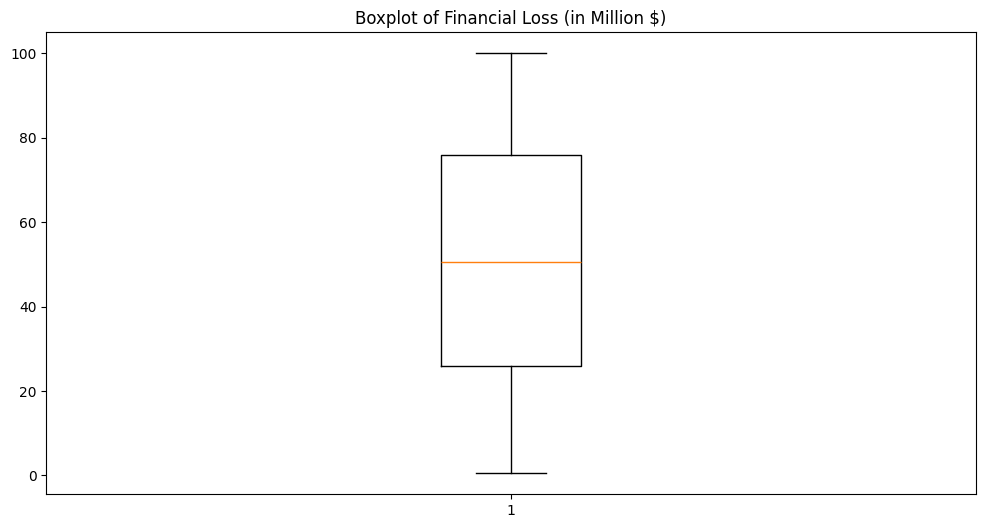

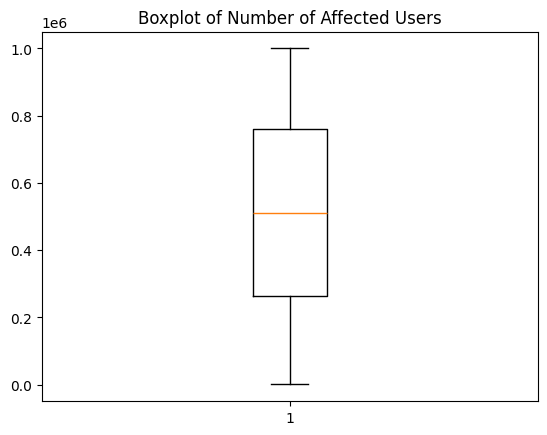

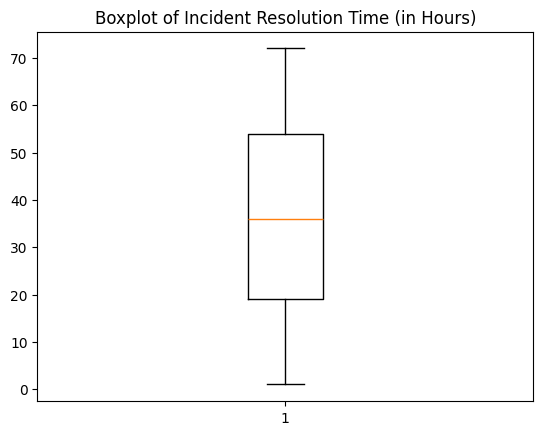

In [6]:
numeric_features = ['Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']
plt.figure(figsize=(12, 6))
for feature in numeric_features:
    plt.boxplot(cybersec_cleaned[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()


TIME SERIES ANALYSIS

Cybersecurity Threats Over the Years

In [4]:
incident_trends = cybersec.groupby('Year', observed=False).size().reset_index(name='Incident Count')
x = incident_trends['Year']
y = incident_trends['Incident Count']
coef = np.polyfit(x, y, 1)
trend = np.poly1d(coef)
incident_trends['Trend'] = trend(x)

# Find peak point
max_idx = incident_trends['Incident Count'].idxmax()
max_year = incident_trends.loc[max_idx, 'Year']
max_value = incident_trends.loc[max_idx, 'Incident Count']

fig = px.line(incident_trends, x='Year', y='Incident Count',
              title='Number of Incidents Over Time',
              labels={'Year': 'Year', 'Incident Count': 'Number of Incidents'},
              markers=True)

# Insert Tendency line
fig.add_trace(go.Scatter(
    x=incident_trends['Year'],
    y=incident_trends['Trend'],
    mode='lines',
    name='Trend Line',
    line=dict(color='orange', dash='dash')
))

# Insert Peak
fig.add_trace(go.Scatter(
    x=[max_year],
    y=[max_value],
    mode='markers+text',
    name='Peak',
    marker=dict(color='red', size=10),
    text=[f"Peak: {max_value}"],
    textposition='top center'
))
fig.update_layout(title_x=0.5, xaxis=dict(tickmode='linear'), width=800, height=500)
fig.show()


C:\Users\LAPTOP ACER\AppData\Local\Temp\ipykernel_22836\2305609782.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_affected, x='Total_Financial_Loss', y='Country', palette='Reds_r')


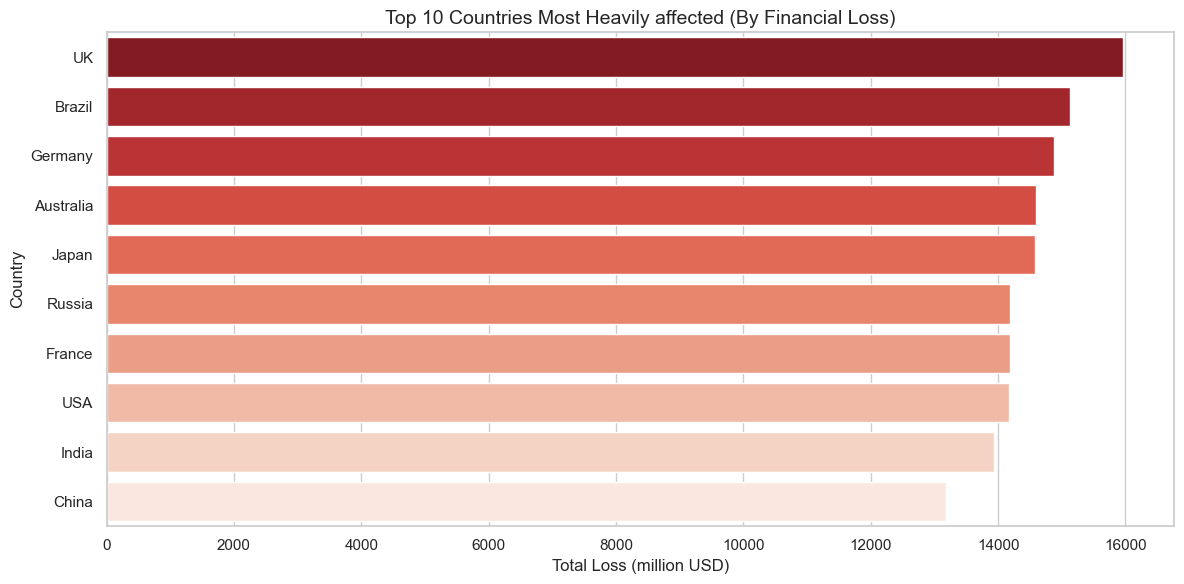

C:\Users\LAPTOP ACER\AppData\Local\Temp\ipykernel_22836\2305609782.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_least_affected, x='Total_Financial_Loss', y='Country', palette='Greens')


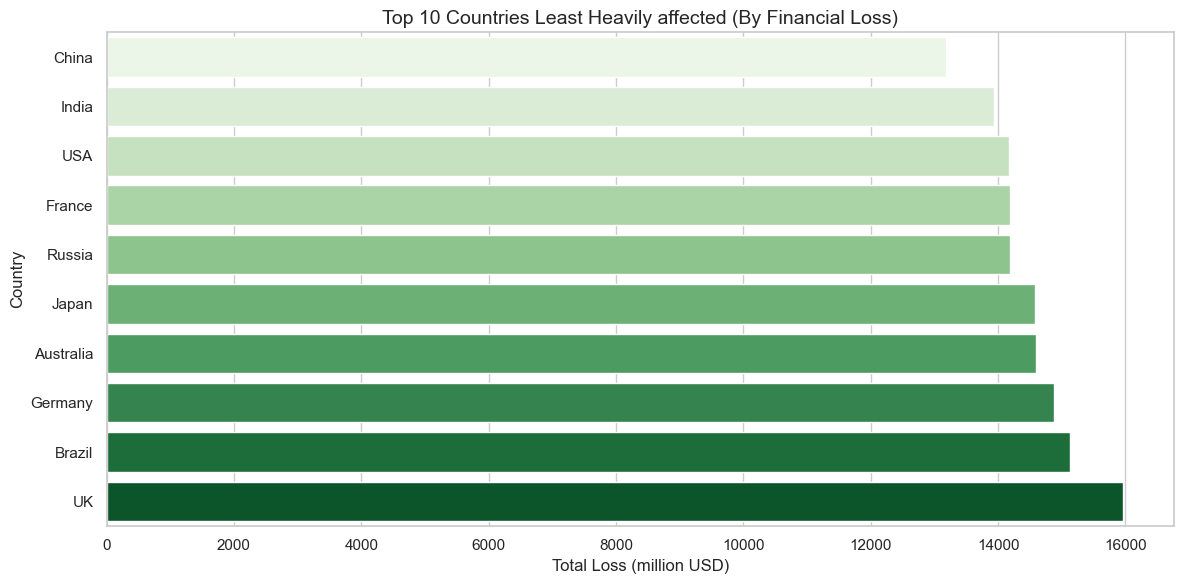

In [11]:
# Gộp dữ liệu theo quốc gia, tính tổng thiệt hại tài chính
country_impact = cybersec.groupby('Country')['Financial Loss (in Million $)'].sum().reset_index()


# Đổi tên cột cho dễ dùng
country_impact.columns = ['Country', 'Total_Financial_Loss']


# Sắp xếp giảm dần để lấy top 10 quốc gia bị ảnh hưởng nặng nhất
top10_affected = country_impact.sort_values(by='Total_Financial_Loss', ascending=False).head(10)


# Sắp xếp tăng dần để lấy top 10 quốc gia ít bị ảnh hưởng nhất (có thể lọc bỏ các giá trị = 0 nếu cần)
top10_least_affected = country_impact[country_impact['Total_Financial_Loss'] > 0] \
                        .sort_values(by='Total_Financial_Loss', ascending=True).head(10)


# Thiết lập style cho Seaborn
sns.set(style="whitegrid")


# Vẽ biểu đồ Top 10 quốc gia bị ảnh hưởng nặng nhất
plt.figure(figsize=(12, 6))
sns.barplot(data=top10_affected, x='Total_Financial_Loss', y='Country', palette='Reds_r')
plt.title('Top 10 Countries Most Heavily affected (By Financial Loss)', fontsize=14)
plt.xlabel('Total Loss (million USD)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()


# Vẽ biểu đồ Top 10 quốc gia ít bị ảnh hưởng nhất
plt.figure(figsize=(12, 6))
sns.barplot(data=top10_least_affected, x='Total_Financial_Loss', y='Country', palette='Greens')
plt.title('Top 10 Countries Least Heavily affected (By Financial Loss)', fontsize=14)
plt.xlabel('Total Loss (million USD)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\LAPTOP ACER\AppData\Local\Temp\ipykernel_22836\1500681834.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cybersec_cleaned['Development_Status'] = cybersec_cleaned['Country'].apply(lambda x: 'Developed' if x in developed_countries else 'Developing')
C:\Users\LAPTOP ACER\AppData\Local\Temp\ipykernel_22836\1500681834.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=impact_by_status, x='Development_Status', y='Financial Loss (in Million $)', palette='coolwarm')


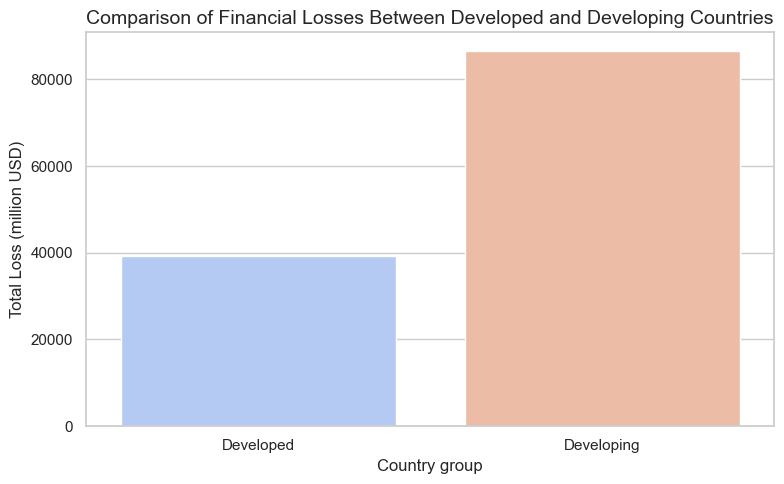

In [12]:
# Tạo danh sách quốc gia phát triển
developed_countries = ['UK', 'France', 'Japan']


# Tạo cột mới: Developed / Developing
cybersec_cleaned['Development_Status'] = cybersec_cleaned['Country'].apply(lambda x: 'Developed' if x in developed_countries else 'Developing')


# Tính tổng thiệt hại theo nhóm quốc gia
impact_by_status = cybersec_cleaned.groupby('Development_Status')['Financial Loss (in Million $)'].sum().reset_index()


# Vẽ biểu đồ so sánh
plt.figure(figsize=(8, 5))
sns.barplot(data=impact_by_status, x='Development_Status', y='Financial Loss (in Million $)', palette='coolwarm')
plt.title('Comparison of Financial Losses Between Developed and Developing Countries', fontsize=14)
plt.xlabel('Country group')
plt.ylabel('Total Loss (million USD)')
plt.tight_layout()
plt.show()

C:\Users\LAPTOP ACER\AppData\Local\Temp\ipykernel_22836\2203189543.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  industry_stats = cybersec_cleaned.groupby('Target Industry').agg({


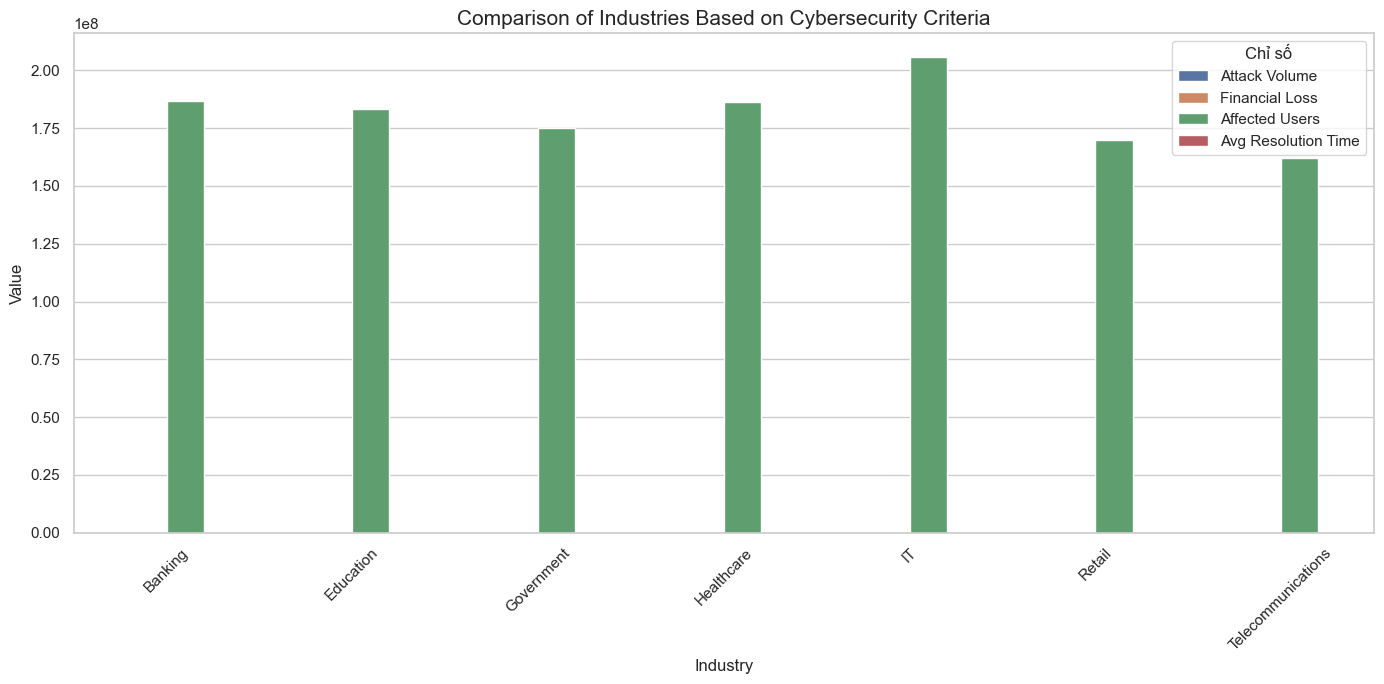

In [14]:
# Tính tổng các chỉ số theo ngành
industry_stats = cybersec_cleaned.groupby('Target Industry').agg({
    'Financial Loss (in Million $)': 'sum',
    'Number of Affected Users': 'sum',
    'Incident Resolution Time (in Hours)': 'mean',
    'Attack Type': 'count'  # volume (số cuộc tấn công)
}).reset_index()


# Đổi tên cột cho dễ nhìn
industry_stats.rename(columns={
    'Attack Type': 'Attack Volume',
    'Financial Loss (in Million $)': 'Financial Loss',
    'Number of Affected Users': 'Affected Users',
    'Incident Resolution Time (in Hours)': 'Avg Resolution Time'
}, inplace=True)


# Chuyển dữ liệu sang dạng "long" để vẽ grouped bar chart
industry_melted = industry_stats.melt(id_vars='Target Industry',
                                      value_vars=['Attack Volume', 'Financial Loss', 'Affected Users', 'Avg Resolution Time'],
                                      var_name='Metric',
                                      value_name='Value')


# Vẽ biểu đồ cột nhóm
plt.figure(figsize=(14, 7))
sns.barplot(data=industry_melted, x='Target Industry', y='Value', hue='Metric')
plt.title('Comparison of Industries Based on Cybersecurity Criteria', fontsize=15)
plt.xlabel('Industry')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Chỉ số')
plt.tight_layout()
plt.show()


C:\Users\Dell E5250\AppData\Local\Temp\ipykernel_16628\1206650855.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Dell E5250\AppData\Local\Temp\ipykernel_16628\1206650855.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




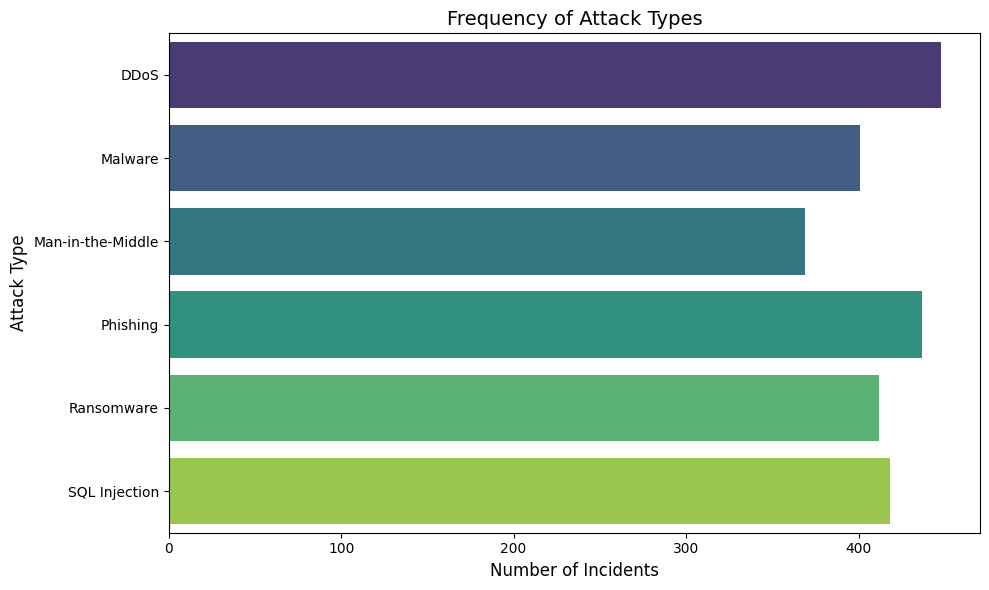

In [10]:
# Nhóm dữ liệu theo Loại Tấn Công để tính tổng số vụ tấn công
attack_type_frequency = cybersec_cleaned.groupby('Attack Type').size().reset_index(name='Number of Incidents')

# Vẽ biểu đồ cột ngang để hiển thị tần suất các loại tấn công
plt.figure(figsize=(10, 6))
sns.barplot(data=attack_type_frequency, x='Number of Incidents', y='Attack Type', palette='viridis')
plt.title('Frequency of Attack Types', fontsize=14)
plt.xlabel('Number of Incidents', fontsize=12)
plt.ylabel('Attack Type', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\Dell E5250\AppData\Local\Temp\ipykernel_16628\3702845239.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



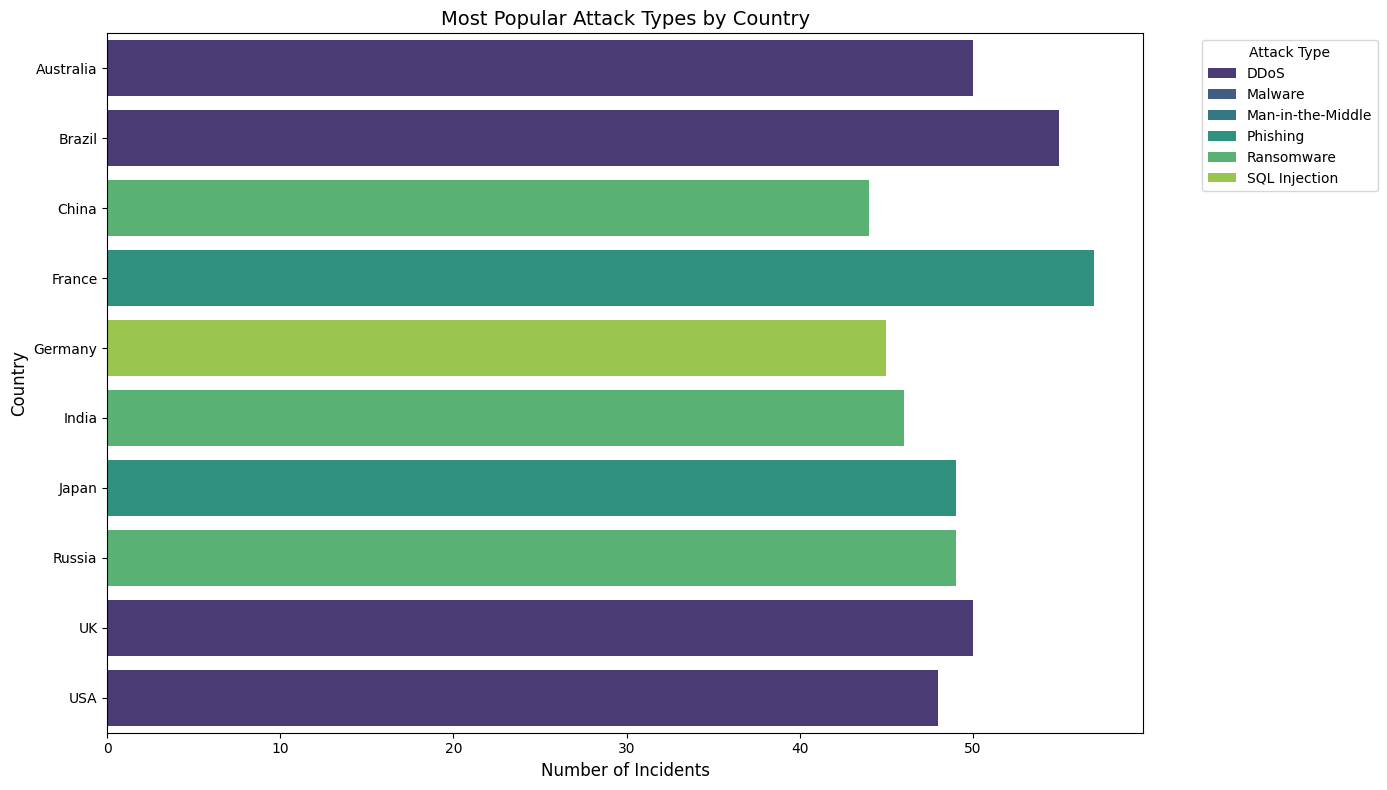

In [23]:
# Nhóm dữ liệu theo Quốc Gia và Loại Tấn Công để tính tổng số vụ tấn công
attack_by_country = cybersec_cleaned.groupby(['Country', 'Attack Type']).size().reset_index(name='Number of Incidents')

# Lấy loại tấn công phổ biến nhất cho mỗi quốc gia
most_popular_attack = attack_by_country.loc[attack_by_country.groupby('Country')['Number of Incidents'].idxmax()]

# Vẽ biểu đồ cột để hiển thị loại tấn công phổ biến nhất theo quốc gia
plt.figure(figsize=(14, 8))
sns.barplot(data=most_popular_attack, x='Number of Incidents', y='Country', hue='Attack Type', palette='viridis')
plt.title('Most Popular Attack Types by Country', fontsize=14)
plt.xlabel('Number of Incidents', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\Dell E5250\AppData\Local\Temp\ipykernel_16628\2953441212.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Dell E5250\AppData\Local\Temp\ipykernel_16628\2953441212.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




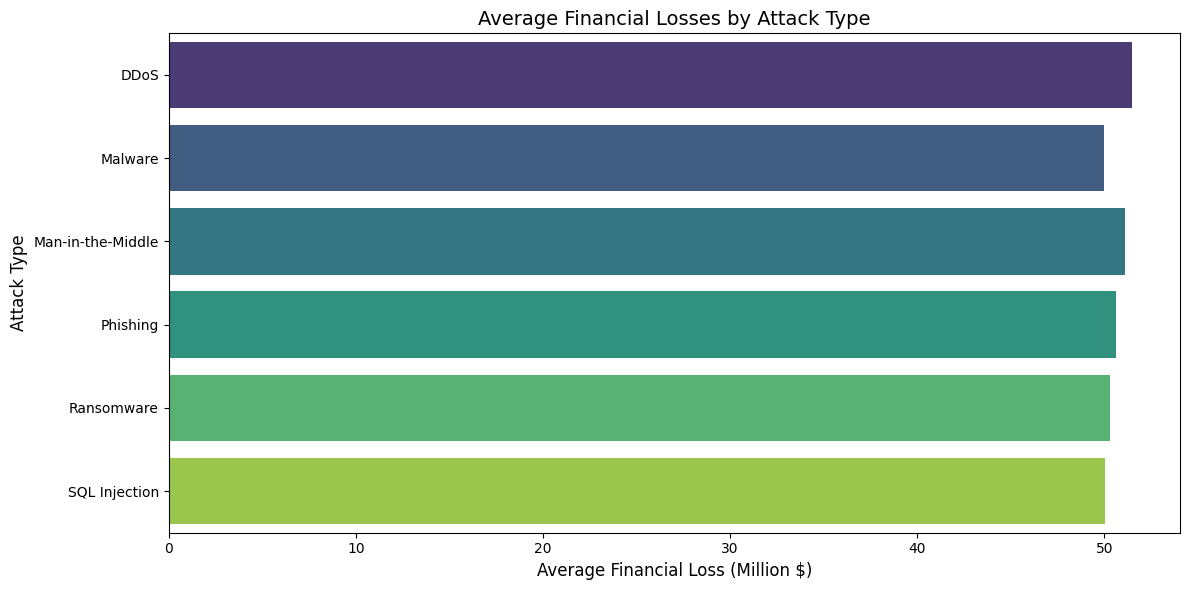

In [21]:
# Tính trung bình thiệt hại tài chính theo loại tấn công
attack_type_losses = cybersec_cleaned.groupby('Attack Type')['Financial Loss (in Million $)'].mean().reset_index()

# Sắp xếp giảm dần theo thiệt hại tài chính trung bình
attack_type_losses = attack_type_losses.sort_values(by='Financial Loss (in Million $)', ascending=False)

# Vẽ biểu đồ cột ngang để hiển thị loại tấn công gây thiệt hại tài chính trung bình cao nhất
plt.figure(figsize=(12, 6))
sns.barplot(data=attack_type_losses, x='Financial Loss (in Million $)', y='Attack Type', palette='viridis')
plt.title('Average Financial Losses by Attack Type', fontsize=14)
plt.xlabel('Average Financial Loss (Million $)', fontsize=12)
plt.ylabel('Attack Type', fontsize=12)
plt.tight_layout()
plt.show()